In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import uqer
import numpy as np
import pandas as pd
from uqer import DataAPI as api
from alphamind.data.store import fetch_data
from alphamind.data.store import risk_styles
from alphamind.data.store import append_industry_info
from alphamind.data.neutralize import neutralize
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')

当前 SDK 版本号是: 1.2.6 已是最新版


In [ ]:
_ = uqer.Client(token='')

In [3]:
ref_date = '20170623'
factor = 'FY12P'

# Algorithm Description
--------------------------

猜测的 ``neutralize`` 残差$\bar Res$计算公式：

$$\bar Res_{i,k} = \bar f_{i,k} - \sum_j \beta_{j,k} \times \bar Ex_{i, j, k}$$

其中：$k$为行业分类，$i$为该行业中第$i$只股票，$j$为第$j$个风险因子。$\bar f$为因子序列，$\bar Ex$为风险暴露矩阵。系数$\beta_{j,k}$由OLS确定。

下面的章节，我们分别比较三种``neutralize``的方法差别：

* **UQER Neutralize**

    使用优矿的SDK计算因子残差。


* **Alpha-Mind Neutralize**

    使用alpha-mind计算因子残差，alpha-mind可以由以下地址安装：
    
    ```
    https://github.com/wegamekinglc/alpha-mind
    ```

* **Direct Linear Regression Implementation**

    直接使用scikit-learn的线性回归功能来计算因子残差。


# Raw Data
---------------------------

In [4]:
factor_data = api.MktStockFactorsOneDayGet(tradeDate=ref_date, field='ticker,' + factor)
risk_factors = api.RMExposureDayGet(tradeDate=ref_date)
append_industry_info(risk_factors)

total_data = pd.merge(factor_data, risk_factors, on=['ticker'])
total_data.set_index('ticker', inplace=True)
total_data.dropna(inplace=True)

In [5]:
len(total_data)

2407

# UQER Neutralize
-----------------------

In [6]:
neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date,
                                          risk_module='day',
                                          industry_type='day')

In [7]:
df = pd.DataFrame(neutralized_factor_uqer, columns=['uqer'])
df.head()

,uqer
000001,0.015150
000002,-0.003985
000006,-0.008520
000008,0.003012
000010,0.020408


In [8]:
len(neutralized_factor_uqer)

2406

# Alpha-Mind Neutralize
--------------------------

In [9]:
x = total_data[risk_styles].values
y = total_data[factor].values
groups = total_data['industry_code'].values.astype(int)

In [10]:
neutralized_factor_alphamind = neutralize(x, y, groups)
alphamind_series = pd.Series(neutralized_factor_alphamind.flatten(), index=total_data.index)

In [11]:
df['alpha-mind'] = alphamind_series

In [12]:
len(alphamind_series)

2407

# The Ticker Missing in UQER but Still in Alpha-Mind
-----------------------------------

In [13]:
missed_codes = [c for c in alphamind_series.index if c not in neutralized_factor_uqer.index]

In [14]:
total_data.ix[missed_codes]

,FY12P,tradeDate,secID,exchangeCD,secShortName,BETA,MOMENTUM,SIZE,EARNYILD,RESVOL,...,Media,IronSteel,NonBankFinan,ELECEQP,AERODEF,Conglomerates,COUNTRY,updateTime,industry,industry_code
ticker,,,,,,,,,,,,,,,,,,,,,
000166,0.0577,20170623,000166.XSHE,XSHE,申万宏源,0.078,-0.916,1.589,-0.758,-1.205,...,0,0,1,0,0,0,1,2017-06-24 09:33:58,NonBankFinan,24


# Direct Linear Regression Implementation
------------------------

In [15]:
model = LinearRegression(fit_intercept=False)

res = np.zeros(len(total_data))

n_groups = np.unique(groups)

for i in n_groups:
    indices = groups == i
    curr_x = x[indices]
    curr_y = y[indices]
    model.fit(curr_x, curr_y)
    res[indices] = curr_y - curr_x @ model.coef_.T

lg_series = pd.Series(res, index=total_data.index)

In [16]:
df['linear_regression'] = lg_series

# Comparison
------------------

In [17]:
df['uqer - linear_regression'] = df['uqer'] - df['linear_regression']
df['alphamind - linear_regression'] = df['alpha-mind'] - df['linear_regression']

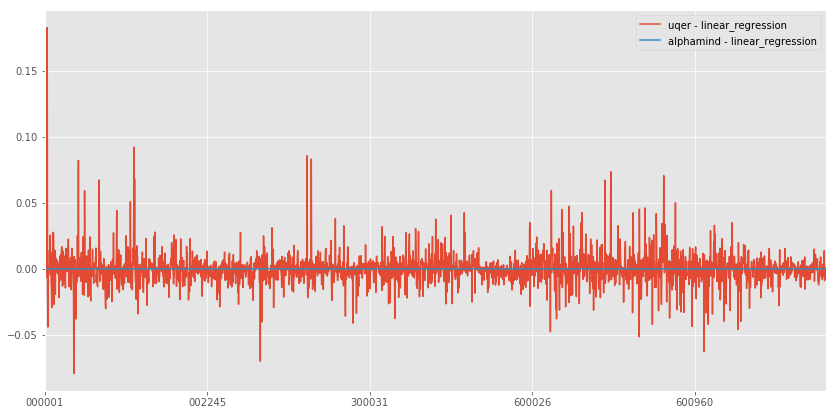

In [18]:
df[['uqer - linear_regression', 'alphamind - linear_regression']].plot(figsize=(14, 7))

# Missing Codes for UQER neutralize in 2017
--------------------------------

In [19]:
from PyFin.api import bizDatesList

In [20]:
biz_dates = bizDatesList('china.sse', '2017-01-05', '2017-07-03')

In [21]:
missed_codes_dict = {}

for date in biz_dates:
    ref_date = date.strftime('%Y%m%d')
    factor_data = api.MktStockFactorsOneDayGet(tradeDate=ref_date, field='ticker,' + factor)
    risk_factors = api.RMExposureDayGet(tradeDate=ref_date)
    append_industry_info(risk_factors)

    total_data = pd.merge(factor_data, risk_factors, on=['ticker'])
    total_data.set_index('ticker', inplace=True)
    total_data.dropna(inplace=True)
    
    neutralized_factor_uqer = uqer.neutralize(total_data[factor],
                                          target_date=ref_date,
                                          risk_module='day',
                                          industry_type='day')
    
    missed_codes = [c for c in total_data.index if c not in neutralized_factor_uqer.index]
    missed_codes_dict[date] = missed_codes

In [22]:
missing_codes = pd.Series(missed_codes_dict)
missing_codes.head()

2017-01-05    [002821]
2017-01-06    [002821]
2017-01-09    [002821]
2017-01-10    [002821]
2017-01-11    [002821]
dtype: object